## Setup

In [1]:
import numpy as np
import pandas as pd
import random

import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable
%matplotlib inline

# Sklearn metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
# Sklearn models
from sklearn.linear_model import Lasso, ElasticNet, Ridge, SGDRegressor
from sklearn.svm import SVR, NuSVR
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
# Sklearn model delection
from sklearn.model_selection import RandomizedSearchCV

# Make results reproducible
random.seed(315)

import warnings
warnings.filterwarnings("ignore")

## Import data

- instant: record index
- dteday : date
- season : season (1:springer, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
- weathersit :
        1: Clear, Few clouds, Partly cloudy, Partly cloudy
        2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
        3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
        4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp: Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

In [14]:
class Dataloader(): 
    '''Bike Sharing Dataset dataloader.    
    '''

    def __init__(self, csv_path):
        ''' Initialize Bike Sharing Dataset dataloader.
        
        Arguments:
            csv_path {str} -- Path to the Bike Sharing Dataset CSV file.
        '''

        self.csv_path = csv_path
        self.data = pd.read_csv(self.csv_path)

        # Shuffle
        self.data.sample(frac=1.0, replace=True, random_state=1)

    def getHeader(self):
        ''' Get the column names of the Bike Sharing CSV file.
        
        Returns:
            [list of str] -- the column names of the csv file
        '''

        return list(self.data.columns.values)

    def getData(self):
        ''' Get the pandas frames for the training, validation and test split
        
        Returns:
            [pandas frames] -- the pandas frames for the different splits
        '''

        # Split data into train, validation and test set with 60:20:20 ratio
        split_train = int(60 / 100 * len(self.data)) 
        split_val = int(80 / 100 * len(self.data)) 
        train = self.data[:split_train]
        val = self.data[split_train:split_val]
        test = self.data[split_val:]
        return train, val,  test

    def getFullData(self):
        ''' Get all the data in one single pandas frame.
        
        Returns:
            [pandas frame] -- the complete Bike Sharing Dataset data
        '''

        return self.data

In [15]:
dataloader = Dataloader('/Users/hongyingyue/Git/python-business-analytics/data/bike/hour.csv')
train, val, test = dataloader.getData()
fullData = dataloader.getFullData()

category_features = ['season', 'holiday', 'mnth', 'hr', 'weekday', 'workingday', 'weathersit']
number_features = ['temp', 'atemp', 'hum', 'windspeed']

features= category_features + number_features
target = ['cnt']

In [16]:
fulldata.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Descriptive Analysis

In [4]:
fulldata.shape

(17379, 17)

In [5]:
category_features = ['season', 'holiday', 'mnth', 'hr', 'weekday', 'workingday', 'weathersit']
number_features = ['temp', 'atemp', 'hum', 'windspeed']

In [6]:
fulldata[number_features].describe()

,temp,atemp,hum,windspeed
count,17379.000000,17379.000000,17379.000000,17379.000000
mean,0.496987,0.475775,0.627229,0.190098
std,0.192556,0.171850,0.192930,0.122340
min,0.020000,0.000000,0.000000,0.000000
25%,0.340000,0.333300,0.480000,0.104500
50%,0.500000,0.484800,0.630000,0.194000
75%,0.660000,0.621200,0.780000,0.253700
max,1.000000,1.000000,1.000000,0.850700


In [7]:
fulldata[category_features] = fulldata[category_features].astype('category')

In [8]:
fulldata[category_features].describe()

,season,holiday,mnth,hr,weekday,workingday,weathersit
count,17379,17379,17379,17379,17379,17379,17379
unique,4,2,12,24,7,2,4
top,3,0,5,17,6,1,1
freq,4496,16879,1488,730,2512,11865,11413


In [9]:
fulldata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   instant     17379 non-null  int64   
 1   dteday      17379 non-null  object  
 2   season      17379 non-null  category
 3   yr          17379 non-null  int64   
 4   mnth        17379 non-null  category
 5   hr          17379 non-null  category
 6   holiday     17379 non-null  category
 7   weekday     17379 non-null  category
 8   workingday  17379 non-null  category
 9   weathersit  17379 non-null  category
 10  temp        17379 non-null  float64 
 11  atemp       17379 non-null  float64 
 12  hum         17379 non-null  float64 
 13  windspeed   17379 non-null  float64 
 14  casual      17379 non-null  int64   
 15  registered  17379 non-null  int64   
 16  cnt         17379 non-null  int64   
dtypes: category(7), float64(4), int64(5), object(1)
memory usage: 1.4+ MB


## Missing Value Analysis

In [10]:
fulldata.isnull().any()

instant       False
dteday        False
season        False
yr            False
mnth          False
hr            False
holiday       False
weekday       False
workingday    False
weathersit    False
temp          False
atemp         False
hum           False
windspeed     False
casual        False
registered    False
cnt           False
dtype: bool

## Outlier Analysis

### Box plots

[Text(0.5, 0, 'Temperature'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Box Plot On Count Across Temperature')]

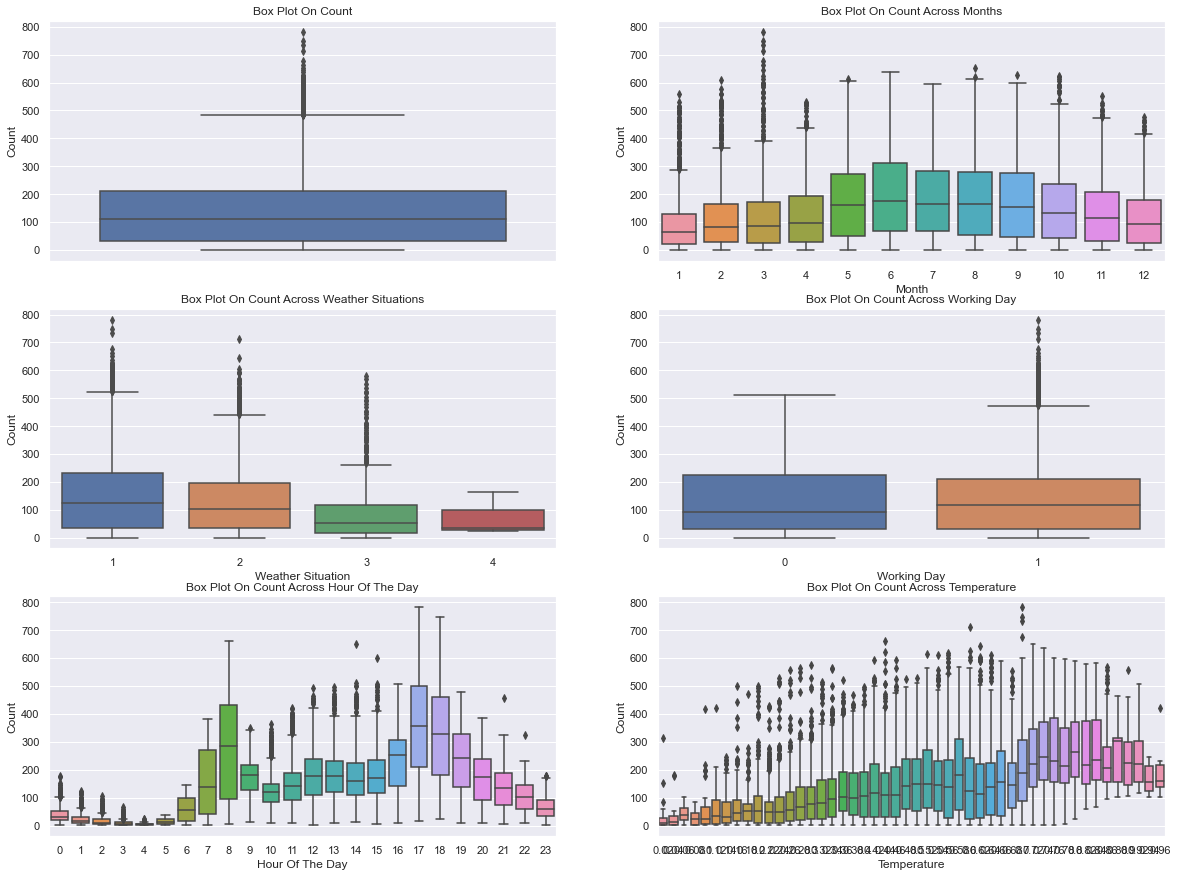

In [17]:
sns.set(font_scale=1.0)
fig, axes = plt.subplots(nrows=3,ncols=2)
fig.set_size_inches(20, 15)

sns.boxplot(data=train,y="cnt",orient="v",ax=axes[0][0])
sns.boxplot(data=train,y="cnt",x="mnth",orient="v",ax=axes[0][1])
sns.boxplot(data=train,y="cnt",x="weathersit",orient="v",ax=axes[1][0])
sns.boxplot(data=train,y="cnt",x="workingday",orient="v",ax=axes[1][1])
sns.boxplot(data=train,y="cnt",x="hr",orient="v",ax=axes[2][0])
sns.boxplot(data=train,y="cnt",x="temp",orient="v",ax=axes[2][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Month', ylabel='Count',title="Box Plot On Count Across Months")
axes[1][0].set(xlabel='Weather Situation', ylabel='Count',title="Box Plot On Count Across Weather Situations")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")
axes[2][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[2][1].set(xlabel='Temperature', ylabel='Count',title="Box Plot On Count Across Temperature")

__Interpretation__: The working day and holiday box plots indicate that more bicycles are rent during normal working days than on weekends or holidays. The hourly box plots show a local maximum at 8 am and one at 5 pm which indicates that most users of the bicycle rental service use the bikes to get to work or school. Another important factor seems to be the temperature: higher temperatures lead to an increasing number of bike rents and lower temperatures not only decrease the average number of rents but also shows more outliers in the data.

### Remove outliers

<AxesSubplot:xlabel='cnt', ylabel='Density'>

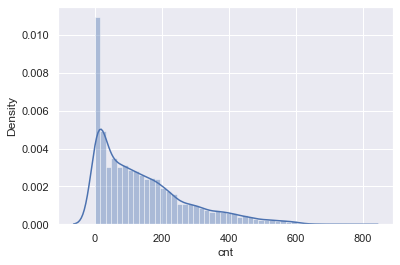

In [18]:
sns.distplot(train[target[-1]])

The distribution plot of the count values reveals that the count values do not match a normal distribution. We will use the median and interquartile range (IQR) to identify and remove outliers from the data. (An alternative approach would be the transformation of the target values to a normal distribution and using mean and standard deviation.)

Samples in train set with outliers: 10427
Samples in train set without outliers: 10151


<AxesSubplot:xlabel='cnt', ylabel='Density'>

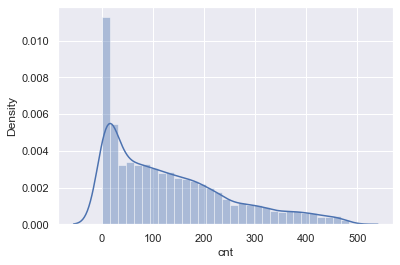

In [24]:
# to use the median and interquartile range (IQR) to identify and remove outliers from the data
print("Samples in train set with outliers: {}".format(len(train)))
q1 = train.cnt.quantile(0.25)
q3 = train.cnt.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 -(1.5 * iqr) 
upper_bound = q3 +(1.5 * iqr) 
train_preprocessed = train.loc[(train.cnt >= lower_bound) & (train.cnt <= upper_bound)]
print("Samples in train set without outliers: {}".format(len(train_preprocessed)))
sns.distplot(train_preprocessed.cnt)

## Correlation Analysis

<AxesSubplot:>

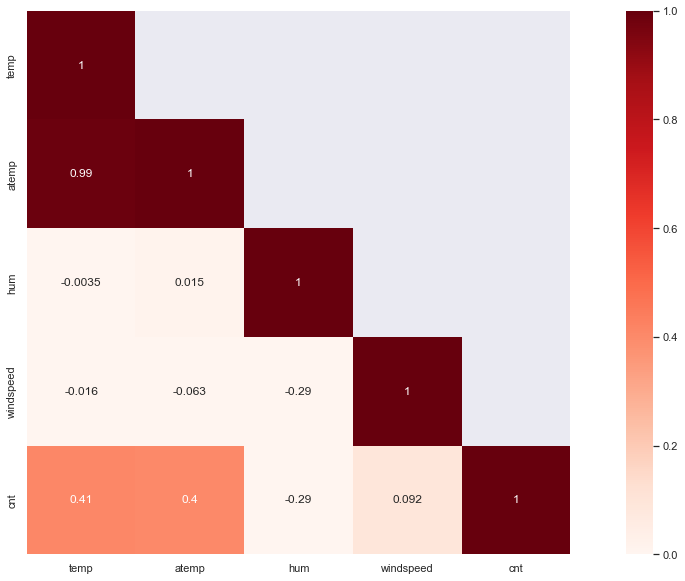

In [25]:
matrix = train[number_features + target].corr()
heat = np.array(matrix)
heat[np.tril_indices_from(heat)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.set(font_scale=1.0)
sns.heatmap(matrix, mask=heat,vmax=1.0, vmin=0.0, square=True,annot=True, cmap="Reds")

__Conclusion__: At the end of the descriptive analysis chapter, we can note the following points:

- Casual and registered contain direct information about the bike sharing count which is to predict (data leakage). Therefore they are not considered in the feature set.
- The variables "temp" and "atemp" are strongly correlated. To reduce the dimensionality of the predictive model, the feature "atemp" is dismissed.
- The variables "hr" and "temp" seem to be promising features for the bike sharing count prediction.

In [26]:
features.remove('atemp')

## Model Selection

The characteristics of the given problem are:

- Regression: The target variable is a quantity.
- Small dataset: Less than 100K samples.
- Few features should be important: The correlation matrix indicates that a few features contain the information to predict the target variable.

This characteristic makes the following methods most promising: 
- Ridge Regression, 
- Support Vector Regression, 
- Ensemble Regressor, 
- Random Forest Regressor.

We will evaluate the performance of these models in the following:

In [27]:
x_train = train_preprocessed[features].values
y_train = train_preprocessed[target].values.ravel()

# Sort validation set for plots
val = val.sort_values(by=target)
x_val = val[features].values
y_val = val[target].values.ravel()
x_test = test[features].values

table = PrettyTable()
table.field_names = ["Model", "Mean Squared Error", "R² score"]

models = [
    SGDRegressor(max_iter=1000, tol=1e-3),
    Lasso(alpha=0.1),
    ElasticNet(random_state=0),
    Ridge(alpha=.5),
    SVR(gamma='auto', kernel='linear'),
    SVR(gamma='auto', kernel='rbf'),
    BaggingRegressor(),
    BaggingRegressor(KNeighborsClassifier(), max_samples=0.5, max_features=0.5),
    NuSVR(gamma='auto'),
    RandomForestRegressor( random_state=0, n_estimators=300)
]

for model in models:
    model.fit(x_train, y_train) 
    y_res = model.predict(x_val)

    mse = mean_squared_error(y_val, y_res)
    score = model.score(x_val, y_val)    

    table.add_row([type(model).__name__, format(mse, '.2f'), format(score, '.2f')])

print(table)

+-----------------------+--------------------+----------+
|         Model         | Mean Squared Error | R² score |
+-----------------------+--------------------+----------+
|      SGDRegressor     |      47311.29      |  -0.02   |
|         Lasso         |      43103.36      |   0.07   |
|       ElasticNet      |      54155.92      |  -0.17   |
|         Ridge         |      42963.88      |   0.07   |
|          SVR          |      50794.63      |  -0.09   |
|          SVR          |      41659.68      |   0.10   |
|    BaggingRegressor   |      18815.21      |   0.59   |
|    BaggingRegressor   |      49564.72      |  -0.07   |
|         NuSVR         |      41517.67      |   0.11   |
| RandomForestRegressor |      18949.93      |   0.59   |
+-----------------------+--------------------+----------+


### Random Forest

In [28]:
# Table setup
table = PrettyTable()
table.field_names = ["Model", "Dataset", "MSE", "MAE", 'RMSLE', "R² score"]

# Model training
model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
model.fit(x_train, y_train) 

def evaluate(x, y, dataset):
    pred = model.predict(x)

    mse = mean_squared_error(y, pred)
    mae = mean_absolute_error(y, pred)
    score = model.score(x, y)    
    rmsle = np.sqrt(mean_squared_log_error(y, pred))

    table.add_row([type(model).__name__, dataset, format(mse, '.2f'), format(mae, '.2f'), format(rmsle, '.2f'), format(score, '.2f')])
    

evaluate(x_train, y_train, 'training')
evaluate(x_val, y_val, 'validation')

print(table)

+-----------------------+------------+----------+-------+-------+----------+
|         Model         |  Dataset   |   MSE    |  MAE  | RMSLE | R² score |
+-----------------------+------------+----------+-------+-------+----------+
| RandomForestRegressor |  training  |  298.72  | 10.93 |  0.21 |   0.98   |
| RandomForestRegressor | validation | 18950.89 | 96.43 |  0.47 |   0.59   |
+-----------------------+------------+----------+-------+-------+----------+


#### Feature Importance

In [30]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x_val.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature hr (0.634371)
2. feature temp (0.159023)
3. feature hum (0.049263)
4. feature workingday (0.047684)
5. feature weathersit (0.027297)
6. feature windspeed (0.026212)
7. feature weekday (0.019981)
8. feature mnth (0.019671)
9. feature season (0.013248)
10. feature holiday (0.003250)


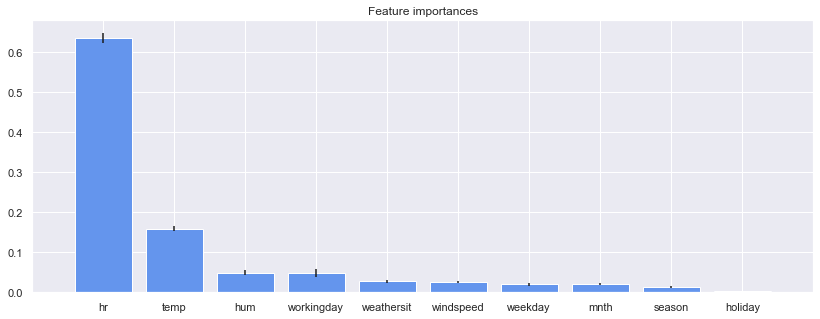

In [31]:
# Plot the feature importances of the forest
plt.figure(figsize=(14,5))
plt.title("Feature importances")
plt.bar(range(x_val.shape[1]), importances[indices], color="cornflowerblue", yerr=std[indices], align="center")
plt.xticks(range(x_val.shape[1]), [features[i] for i in indices])
plt.xlim([-1, x_val.shape[1]])
plt.show()

Interpretation: The result corresponds to the high correlation of the hour and temperature variable with the bicycle sharing count in the feature correlation matrix.

## Future Work
Here are some ideas of future work to improve the performance of the data model further:

- Distribution adjustment of the target variable: Some predictive models assume a normal distribution of the target variable - a transformation in the data preprocessing could improve the performance of such methods.
- Bagging Regression seems in better performance than Random Forest.